In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display, Image
from scipy import stats
from sklearn.decomposition import PCA
import statsmodels.api as sm
from matplotlib_venn import venn3

**Figure 5A**

In [2]:
df=pd.read_csv('Sleuth_results_all.txt')
x=df.groupby('ens_gene').target_id.count()
isoform_genes=np.array(x[x>1].index)
df_abundance=pd.read_pickle('GTEx_mTEC_expression_transcript.pkl')

In [3]:
for i,x in enumerate(isoform_genes):
    expression=df_abundance.loc[np.array(df[df.ens_gene==x].target_id)]
    gene_entropy=stats.entropy(expression,base=2)
    if i==0:
        genes=np.hstack((x,gene_entropy))
    else:
        genes=np.vstack((genes,np.hstack((x,gene_entropy))))

/Users/hannah/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2686: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


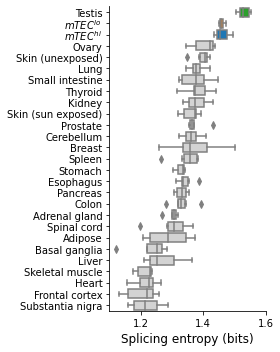

In [7]:
x=pd.DataFrame(genes)
x.to_pickle('GTEx_mTEC_entropies.pkl')
x.index=np.array(x[0])
x=x.drop(columns=[0])
x=x.astype(float)
x.columns=df_abundance.columns

z=x.mean()
z1=[x.split('_GTEX')[0] if 'GTEX' in x else x.split('_')[0]+x.split('_')[2] for x in z.index]
z=pd.DataFrame(np.vstack((z,z1)).T,columns=['Entropy','Tissue'])
z.Entropy=z.Entropy.astype(float)




In [10]:
plt.figure(figsize=(3,6))
order_names=['Testis','$mTEC^{lo}$','$mTEC^{hi}$','Ovary','Skin (unexposed)','Lung','Small intestine','Thyroid', 'Kidney','Skin (sun exposed)','Prostate','Cerebellum','Breast','Spleen','Stomach','Esophagus','Pancreas','Colon','Adrenal gland','Spinal cord','Adipose','Basal ganglia','Liver','Skeletal muscle','Heart','Frontal cortex', 'Substantia nigra']
ax=sns.boxplot(y='Tissue',x='Entropy',data=z,order=z.groupby('Tissue').Entropy.median().sort_values(ascending=False).index,palette=['lightgray'])
for i,patch in enumerate(ax.artists):
    if i==1:
        patch.set_facecolor(sns.color_palette()[1])
    elif i==2:
        patch.set_facecolor(sns.color_palette()[0])
    elif i==0:
        patch.set_facecolor(sns.color_palette()[2])
sns.despine()
plt.yticks(np.arange(len(order_names)),order_names,fontsize=10)#,rotation=90)
plt.xticks(np.arange(1,1.6,.2),fontsize=10)
plt.xlim([1.1,1.6])
plt.xlabel('Splicing entropy (bits)',fontsize=12)
plt.ylabel('')
plt.savefig('figure5a.pdf', bbox_inches="tight")
plt.close()

**Figure 5B**

In [11]:
genes=pd.read_pickle('GTEx_mTEC_expression_transcript.pkl')
genes.columns=[x.split('_GTEX')[0] if 'GTEX' in x else x.split('_')[2] for x in genes.columns]

In [12]:
i=0
for threshold in np.arange(0,10,.01):
    x=pd.DataFrame(((1*(genes>threshold)).sum())/genes.shape[0])
    x['Tissue']=np.array(x.index)
    x['Threshold']=[threshold]*x.shape[0]
    if i==0:
        z=x.groupby('Tissue').median()
    else:
        z=z.append(x.groupby('Tissue').median())
    i+=1
z=pd.DataFrame(z)
z.columns=['Fraction','Threshold']
z.Threshold=z.Threshold.astype(float)
z['Tissue']=np.array(z.index)

x=1*(genes>1).sum()
count=[]
for a in x.index.unique():
    count.append(x[a].mean())
df_transcript=pd.DataFrame(np.vstack((x.index.unique(),count)).T,columns=['Tissue','Count'])

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(8,5))
for x in z[~ z.Tissue.isin(['lo','hi','Testis'])].Tissue.unique():
    sns.lineplot(x='Threshold',y='Fraction',hue='Tissue',data=z[z.Tissue==x],lw=2,palette=['lightgray'])
sns.lineplot(x='Threshold',y='Fraction',hue='Tissue',data=z[z.Tissue=='lo'],lw=4,palette=[sns.color_palette()[1]],label='lo')
sns.lineplot(x='Threshold',y='Fraction',hue='Tissue',data=z[z.Tissue=='hi'],lw=4,palette=[sns.color_palette()[0]],label='hi')
sns.lineplot(x='Threshold',y='Fraction',hue='Tissue',data=z[z.Tissue=='Testis'],lw=4,palette=[sns.color_palette()[2]],label='Testis')
plt.plot([1,1],[0,.9],'--k')
plt.xscale('log')
sns.despine()
plt.legend('',frameon=False)
plt.xticks([.01,.1,1,10],[.01,.1,1,10],fontsize=17.5)
plt.ylim([0,.9])
plt.yticks(np.arange(0,1,.2),fontsize=17.5)
plt.xlabel('Threshold (TPM)',fontsize=20)
plt.ylabel('Fraction expressed transcripts',fontsize=18)
plt.tight_layout()
plt.show()
plt.close()

**Figure 5C**

In [ ]:
sleuth=pd.read_csv('Sleuth_results_all.txt')
df_abundance=pd.read_pickle('GTEx_mTEC_expression_transcript.pkl')
genes=pd.DataFrame(np.zeros((sleuth.ens_gene.unique().shape[0],df_abundance.shape[1])),index=sleuth.ens_gene.unique(),columns=df_abundance.columns)
for x in genes.index:
    genes.loc[x]=df_abundance.loc[sleuth[sleuth.ens_gene==x].target_id].sum()

In [ ]:
genes.columns=[x.split('_GTEX')[0] if 'GTEX' in x else x.split('_')[2] for x in genes.columns]

In [ ]:
x=1*(genes>1).sum()
count=[]
for a in x.index.unique():
    count.append(x[a].mean())

In [ ]:
df_genes=pd.DataFrame(np.vstack((x.index.unique(),count)).T,columns=['Tissue','Count'])

In [ ]:
df_genes['Transcripts']=df_transcript.loc[df_genes.index].Count.astype(float)
df_genes.Count=df_genes.Count.astype(float)
df_genes.columns=['Tissue','Genes','Transcripts']
df_genes=df_genes.sort_values(by='Transcripts',ascending=False)

In [ ]:
colors=np.hstack((sns.color_palette()[2],sns.color_palette()[1],sns.color_palette()[0],sns.color_palette()[7]*(df_genes.shape[0]-3)))
colors=colors.reshape(int(colors.shape[0]/3),3)
plt.figure(figsize=(6,4))
sns.regplot(x='Genes',y='Transcripts',data=df_genes,truncate=False,scatter_kws={"color": colors,'s':100}, line_kws={"color": "Grey"})
plt.ylim([25000,75000])
plt.yticks(fontsize=11)
plt.xticks(fontsize=11,rotation=45)
plt.ylabel('Expressed transcripts',fontsize=15)
plt.xlabel('Expressed genes',fontsize=15)
sns.despine()
plt.tight_layout()
plt.show()
plt.close()

**Figure 5D**

In [ ]:
SE=pd.read_csv('SE.MATS.JCEC.txt',sep='\t')
RI=pd.read_csv('RI.MATS.JCEC.txt',sep='\t')
MXE=pd.read_csv('MXE.MATS.JCEC.txt',sep='\t')
A5SS=pd.read_csv('A5SS.MATS.JCEC.txt',sep='\t')
A3SS=pd.read_csv('A3SS.MATS.JCEC.txt',sep='\t')
SE=SE[(SE.FDR.astype(float)<0.05) & (abs(SE.IncLevelDifference)>0.1)]
RI=RI[(RI.FDR.astype(float)<0.05) & (abs(RI.IncLevelDifference)>0.1)]
MXE=MXE[(MXE.FDR.astype(float)<0.05) & (abs(MXE.IncLevelDifference)>0.1)]
A5SS=A5SS[(A5SS.FDR.astype(float)<0.05) & (abs(A5SS.IncLevelDifference)>0.1)]
A3SS=A3SS[(A3SS.FDR.astype(float)<0.05) & (abs(A3SS.IncLevelDifference)>0.1)]

In [ ]:
row=[]
for df1,name in zip([SE,RI,MXE,A5SS,A3SS],['SE','RI','MXE','A5SS','A3SS']):
        high=df1[df1.IncLevelDifference>0].shape[0]
        low=df1[df1.IncLevelDifference<0].shape[0]
        row.append([name,high,low])
splice=pd.DataFrame(row,columns=['Splice','mTEC_hi','mTEC_lo'])

In [ ]:
df1=splice.melt( id_vars=['Splice'], value_vars=['mTEC_lo','mTEC_hi'])
sns.barplot(x='Splice',y='value',hue='variable',data=df1,palette=[sns.color_palette()[1],sns.color_palette()[0]])
plt.ylabel('Count',fontsize=15)
plt.xlabel('')
sns.despine()
plt.legend('',frameon=False)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.ylim([50,1400])
plt.xticks(fontsize=15)
plt.tight_layout()
plt.show()
plt.close()

**Figure 5E**

In [13]:
df=pd.read_csv('Sleuth_results_all.txt')
df=df.sort_values(by='qval')
df=df[df.ens_gene.astype(str)!='nan']
df_abundance=pd.read_pickle('Kallisto_abundance.pkl')

In [16]:
splicing=pd.read_csv('Zhang_2020_NatComm_SRGs.txt',header=None)
splicing=np.array(splicing[0])
splicing=np.hstack((splicing,['SFSWAP', 'SF3A1', 'SF3A1', 'SF3A1', 'SF3A1', 'SRSF5', 'SRSF5', 'SRSF5',
       'SRSF5', 'SRSF3', 'SRSF3', 'SRSF3', 'SRSF7', 'SRSF7', 'SRSF7', 'SFPQ',
       'SRSF2', 'SRSF2', 'SRSF2']))
splicing=np.hstack((splicing,['SNRPN','PABPN1L','DPPA5','ZC3H12D','LARP6','MSI1','SYNJ2']))
splicing=np.hstack((splicing,['BRDT','CELF4','CELF6','CWC22','ELAVL2','ELAVL3','ELAVL4','ESRP1','KHDRBS2','MBNL3','MSI1','NOVA1','NOVA2',
         'RBFOX1','RBFOX2','RBM11','RBM20','RBM24','SLU7','SNRPN','SRPK2','SRPK3','SRRM4','SYNCRIP']))
splicing=np.hstack((splicing,['ESRP1','ESRP2']))
splicing=np.unique(splicing)

In [17]:
s=['pt214_lo_tpm','pt221_lo_tpm','pt226_lo_tpm','pt214_hi_tpm','pt221_hi_tpm','pt226_hi_tpm']

In [20]:
t=[]
g=[]
b=[]
for gene in splicing:
    x=df[df.ext_gene==gene]
    x=x[x.qval<0.05]
    t=np.hstack((t,x.target_id))
    g=np.hstack((g,x.ext_gene))
    b=np.hstack((b,x.b))
x=df_abundance.loc[t]
x.index=np.array(g)
cm=sns.clustermap(np.log2(x[s]+0.1),robust=True,col_cluster=0,
               cmap='coolwarm',z_score=0,center=0,figsize=(5,20))
cm.cax.set_visible(False)
plt.show()
plt.close()